## Homework 4

Use this notebook as a starter

In [105]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [116]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [117]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [118]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [119]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [120]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [121]:
numerical = list(df._get_numeric_data().columns)
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

In [122]:
categorical = list(set(df.columns) - set(cat))
categorical

['home', 'job', 'marital', 'records']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [123]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values


print(df_train.shape[0], df_val.shape[0], df_test.shape[0])
print(y_train.shape[0], y_val.shape[0], y_test.shape[0])

2672 891 891
2672 891 891


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [218]:
from sklearn.metrics import roc_auc_score
import operator


scores = {}
for c in (set(numerical)-set(['default'])):
    
    score = roc_auc_score(df_train.default, df_train[c])
    scores[c] = score
    #print('column name: {}, the roc_auc score: {}'.format(c, score))
sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

[('amount', 0.588419133578477),
 ('time', 0.5614152707102973),
 ('expenses', 0.5010232886379675),
 ('debt', 0.49949237950203673),
 ('price', 0.4855854350060047),
 ('age', 0.4330754992633313),
 ('assets', 0.36515401948767473),
 ('income', 0.3134776337456202),
 ('seniority', 0.2976321360918174)]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [219]:
cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

df_train = df_train[cols]
df_val = df_val[cols]
df_test = df_test[cols]

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [221]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [222]:
from sklearn.metrics import roc_auc_score
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [223]:
y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8054980087218927

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [224]:
def precision_recall_f1_scores(y_val, y_pred):
    
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = []
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        p = tp / (tp + fp)
        r = tp / (tp + fn)
        f1 = 2 * p * r / (p + r)

        scores.append((p, r, f1))
        
    
    return scores

In [225]:
scores = precision_recall_f1_scores(y_val, y_pred)

<ipython-input-224-e6c09887db47>:19: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


In [226]:
scores_df = pd.DataFrame(scores, columns=['precision', 'recall', 'f1'])
scores_df['threshold'] = thresholds
scores_df

,precision,recall,f1,threshold
0,0.296348,1.000000,0.457205,0.00
1,0.300142,1.000000,0.461707,0.01
2,0.302460,0.990521,0.463415,0.02
3,0.307238,0.985782,0.468468,0.03
4,0.314675,0.985782,0.477064,0.04
...,...,...,...,...
96,NaN,0.000000,NaN,0.96
97,NaN,0.000000,NaN,0.97
98,NaN,0.000000,NaN,0.98
99,NaN,0.000000,NaN,0.99


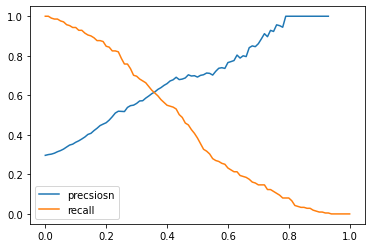

In [227]:
plt.plot(scores_df['threshold'], scores_df['precision'], label='precsiosn')
plt.plot(scores_df['threshold'], scores_df['recall'], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

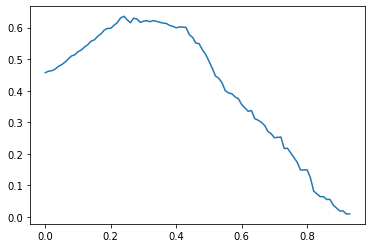

In [228]:
plt.plot(scores_df['threshold'], scores_df['f1'])

In [177]:
scores_df['threshold'][scores_df['f1'] == max(scores_df['f1'])]

30    0.3
Name: threshold, dtype: float64

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [235]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [236]:
def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [237]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [238]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.826 +- 0.000
0.826 +- 0.000
0.813 +- 0.017
0.814 +- 0.015
0.812 +- 0.014


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [239]:
for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.812 +- 0.013
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C